# 현대제철 냉연공정 결로 데이터 분석

In [1]:
# Package Import
import numpy as np
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 송악읍 기상데이터 전처리

In [2]:
dongne_weather = pd.read_csv('C:/Users/svsta/OneDrive/Portfolio/공모전/날씨 빅데이터 콘테스트/당진시 송악읍 자료/dongne_201006_201905.csv')
dongne_weather.dropna(inplace=True)
dongne_weather.reset_index(inplace=True)

temp = []
for i in dongne_weather['ymdhm']:
    time_x = 0
    
    timeobj = datetime.strptime(str(i), '%Y%m%d %H:%M').timetuple()
    
    temp.append(time.mktime(timeobj))

dongne_weather['datetime_x'] = temp
dongne_weather = dongne_weather[dongne_weather['rain'] != -1]
dongne_weather = dongne_weather[dongne_weather['humidity'] != -1]

# 날짜 추가
temp = []
for i in list(dongne_weather['ymdhm']):
    temp.append(i[0:8])
    
len(temp)
dongne_weather['date_x'] = temp
# 일별 온도, 습도의 최대, 최소, 평균 계산
dongne_weather_day_max = dongne_weather.groupby('date_x').max()
dongne_weather_day_min = dongne_weather.groupby('date_x').min()
dongne_weather_day_mean = dongne_weather.groupby('date_x').mean()

# 필요없는 Column 삭제
dongne_weather_day_max.drop(['ymdhm','index', 'weather', 'direction', 'velocity', 'datetime_x'], axis='columns', inplace=True)
dongne_weather_day_min.drop(['ymdhm', 'index', 'weather', 'direction', 'velocity', 'datetime_x'], axis='columns', inplace=True)
dongne_weather_day_mean.drop(['index', 'weather', 'direction', 'velocity', 'datetime_x'], axis='columns', inplace=True)

# Column Names 변경
dongne_weather_day_max.columns = ['max_hum', 'max_rain', 'max_tem']
dongne_weather_day_min.columns = ['min_hum', 'min_rain', 'min_tem']
dongne_weather_day_mean.columns = ['mean_hum', 'mean_rain', 'mean_tem']



# 연도 별 데이터 분류, 4년 연 평균 계산

In [3]:
# 연도 별 데이터 분류

# 2016년 (윤년 2/29 제외)
year_weather2016 = dongne_weather_day_max[2040:2406]
year_weather2016 = pd.concat([dongne_weather_day_max[2040:2406], 
                            dongne_weather_day_min[2040:2406],
                            dongne_weather_day_mean[2040:2406]], axis=1)
year_weather2016.drop(['20160229'], axis=0, inplace=True)

# 2017년
year_weather2017 = dongne_weather_day_max[2406:2771]
year_weather2017 = pd.concat([dongne_weather_day_max[2406:2771], 
                            dongne_weather_day_min[2406:2771],
                            dongne_weather_day_mean[2406:2771]], axis=1)

# 2018년
year_weather2018 = dongne_weather_day_max[2771:3136]
year_weather2018 = pd.concat([dongne_weather_day_max[2771:3136], 
                            dongne_weather_day_min[2771:3136],
                            dongne_weather_day_mean[2771:3136]], axis=1)

# 2019년
year_weather2019 = dongne_weather_day_max[3136:3501]
year_weather2019 = pd.concat([dongne_weather_day_max[3136:3501], 
                            dongne_weather_day_min[3136:3501],
                            dongne_weather_day_mean[3136:3501]], axis=1)

# 2020년 * ~3/31 (윤년 2/29 포함)
year_weather2020 = dongne_weather_day_max[3501:-61]
year_weather2020 = pd.concat([dongne_weather_day_max[3501:-61], 
                            dongne_weather_day_min[3501:-61],
                            dongne_weather_day_mean[3501:-61]], axis=1)

# index 를 같게 설정 (index number = 1/1 ~ 12/31), 기존 index 제거
year_weather2016.reset_index(inplace=True)
year_weather2017.reset_index(inplace=True)
year_weather2018.reset_index(inplace=True)
year_weather2019.reset_index(inplace=True)

year_weather2016tmp = year_weather2016.drop(['date_x'], axis='columns')
year_weather2017tmp = year_weather2017.drop(['date_x'], axis='columns')
year_weather2018tmp = year_weather2018.drop(['date_x'], axis='columns')
year_weather2019tmp = year_weather2019.drop(['date_x'], axis='columns')

# 4년 연평균 max, min, mean 계산
year_average = (year_weather2016tmp + year_weather2017tmp + year_weather2018tmp + year_weather2019tmp)/4


# 공장 데이터 전처리, 연 평균 기온

In [5]:
# plant1 데이터 전처리
p1tmp = pd.read_csv('C:/Users/svsta/OneDrive/Portfolio/공모전/날씨 빅데이터 콘테스트/plant1_train.csv')
p1tmp.dropna(inplace=True)

temp = []
for i in p1tmp['plant1_train.mea_ddhr']:
    time_x = 0
    timeobj = datetime.strptime(str(i), '%Y-%m-%d %H:%M').timetuple()
    temp.append(time.mktime(timeobj))
p1tmp['datetime_x'] = temp

# plant2 데이터 전처리
p2tmp = pd.read_csv('C:/Users/svsta/OneDrive/Portfolio/공모전/날씨 빅데이터 콘테스트/plant2_train.csv')
p2tmp.dropna(inplace=True)

temp = []
for i in p2tmp['plant2_train.mea_ddhr']:
    time_x = 0
    timeobj = datetime.strptime(str(i), '%Y-%m-%d %H:%M').timetuple()
    temp.append(time.mktime(timeobj))
p2tmp['datetime_x'] = temp


In [241]:
p1tmp

,Unnamed: 0,plant1_train.mea_ddhr,plant1_train.tem_in_loc1,plant1_train.hum_in_loc1,plant1_train.tem_coil_loc1,plant1_train.tem_in_loc2,plant1_train.hum_in_loc2,plant1_train.tem_coil_loc2,plant1_train.tem_in_loc3,plant1_train.hum_in_loc3,plant1_train.tem_coil_loc3,plant1_train.tem_out_loc1,plant1_train.hum_out_loc1,plant1_train.cond_loc1,plant1_train.cond_loc2,plant1_train.cond_loc3,datetime_x,date_x,time_x
0,1,2016-04-01 0:00,16.00,24.00,11.00,14.00,23.00,11.00,13.00,32.00,10.00,9.00,42.00,0.0,0.0,0.0,1.459436e+09,0401,0
1,2,2016-04-01 3:00,14.00,28.00,10.00,12.00,32.00,9.00,11.00,42.00,7.00,7.00,59.00,0.0,0.0,0.0,1.459447e+09,0401,300
2,3,2016-04-01 6:00,13.00,33.00,10.00,11.00,37.00,9.00,10.00,44.00,7.00,6.00,56.00,0.0,0.0,0.0,1.459458e+09,0401,600
3,4,2016-04-01 9:00,13.00,33.00,10.00,11.00,35.00,9.00,10.00,41.00,8.00,18.00,30.00,0.0,0.0,0.0,1.459469e+09,0401,900
4,5,2016-04-01 12:00,16.00,28.00,10.00,15.00,27.00,11.00,14.00,30.00,9.00,18.00,20.00,0.0,0.0,0.0,1.459480e+09,0401,1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58744,58745,2019-03-31 23:10,10.52,36.39,10.52,10.55,35.20,11.17,9.85,37.88,9.79,6.40,43.86,0.0,0.0,0.0,1.554041e+09,0331,2310
58745,58746,2019-03-31 23:20,10.52,37.09,10.44,10.55,35.53,11.09,9.88,38.40,9.72,6.34,44.02,0.0,0.0,0.0,1.554042e+09,0331,2320
58746,58747,2019-03-31 23:30,10.43,37.18,10.56,10.49,35.65,11.21,9.85,38.22,9.91,6.40,43.04,0.0,0.0,0.0,1.554043e+09,0331,2330
58747,58748,2019-03-31 23:40,10.49,38.00,10.56,10.55,36.08,11.21,9.82,38.95,9.83,6.31,45.33,0.0,0.0,0.0,1.554043e+09,0331,2340


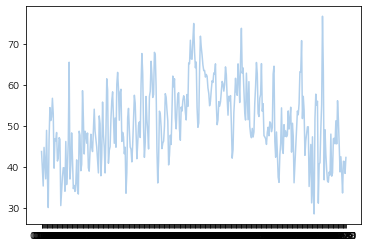

In [248]:
# 연속시간선상으로 PLOTTING 
# plt.plot(p1tmp.set_index('datetime_x')['plant1_train.hum_out_loc1'], color = '#deebf7')

plt.plot(p1tmp.groupby(['date_x']).mean()['plant1_train.hum_in_loc1'], color = '#b2d0ec')


In [7]:
# 공장 별 일간 최대, 최소, 평균 기온, 습도
temp = []
for i in list(p1tmp['plant1_train.mea_ddhr']):
    temp.append(i[5:10].replace('-',''))
    
len(temp)
p1tmp['date_x'] = temp

p1tmp_day_max = p1tmp.groupby('date_x').max()
p1tmp_day_min = p1tmp.groupby('date_x').min()
p1tmp_day_mean = p1tmp.groupby('date_x').mean()

temp = []
for i in list(p2tmp['plant2_train.mea_ddhr']):
    temp.append(i[5:10].replace('-',''))
    
len(temp)
p2tmp['date_x'] = temp

p2tmp_day_max = p2tmp.groupby('date_x').max()
p2tmp_day_min = p2tmp.groupby('date_x').min()
p2tmp_day_mean = p2tmp.groupby('date_x').mean()

# 연간 시간대별 온도, 습도 변화 시계열 분석

In [9]:
# 연간 시계열 분석

# Plant 1
temp = []
for i in list(p1tmp['plant1_train.mea_ddhr']):
    temp.append(i.split()[1].replace(':',''))
    
p1tmp['time_x'] = list(map(int,temp))

# 연간 시간별 평균값 계산
p1time = p1tmp.groupby('time_x').mean()

# Plant 2
temp = []
for i in list(p2tmp['plant2_train.mea_ddhr']):
    temp.append(i.split()[1].replace(':',''))
    
p2tmp['time_x'] = list(map(int,temp))

# 연간 시간별 평균값 계산
p2time = p2tmp.groupby('time_x').mean()

In [10]:
# Smooth Function
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [11]:
# Plant 1 Time Series 공장 내부 온도
p1_tem_times = []
for i in range(1,4):
    y = p1time['plant1_train.tem_in_loc{}'.format(i)]
    temp_y=[]
    for j in range(len(y)):
        if j==0:
            temp_y.append(smooth(y,3)[j+1]-np.mean(smooth(y,3)))
            continue
        if j%3 == 0:
            temp_y.append(smooth(y,3)[j]-np.mean(smooth(y,3)))
    p1_tem_times.append(temp_y)

# Plant 1 Time Series 코일 온도
p1_coil_times = []
for i in range(1,4):
    y = p1time['plant1_train.tem_coil_loc{}'.format(i)]
    temp_y=[]
    for j in range(len(y)):
        if j==0:
            temp_y.append(smooth(y,3)[j+1]-np.mean(smooth(y,3)))
            continue
        if j%3 == 0:
            temp_y.append(smooth(y,3)[j]-np.mean(smooth(y,3)))
    p1_coil_times.append(temp_y)

# Plant 1 Time Series 습도
p1_hum_times = []
for i in range(1,4):
    y = p1time['plant1_train.hum_in_loc{}'.format(i)]
    temp_y=[]
    for j in range(len(y)):
        if j==0:
            temp_y.append(smooth(y,3)[j+1]-np.mean(smooth(y,3)))
            continue
        if j%3 == 0:
            temp_y.append(smooth(y,3)[j]-np.mean(smooth(y,3)))
    p1_hum_times.append(temp_y)

In [12]:
# Plant 1 Time Series 공장 내부 온도
p2_tem_times = []
for i in range(1,4):
    y = p2time['plant2_train.tem_in_loc{}'.format(i)]
    temp_y=[]
    for j in range(len(y)):
        if j==0:
            temp_y.append(smooth(y,3)[j+1]-np.mean(smooth(y,3)))
            continue
        if j%3 == 0:
            temp_y.append(smooth(y,3)[j]-np.mean(smooth(y,3)))
    p2_tem_times.append(temp_y)

# Plant 2 Time Series 코일 온도
p2_coil_times = []
for i in range(1,4):
    y = p2time['plant2_train.tem_coil_loc{}'.format(i)]
    temp_y=[]
    for j in range(len(y)):
        if j==0:
            temp_y.append(smooth(y,3)[j+1]-np.mean(smooth(y,3)))
            continue
        if j%3 == 0:
            temp_y.append(smooth(y,3)[j]-np.mean(smooth(y,3)))
    p2_coil_times.append(temp_y)

# Plant 1 Time Series 습도
p2_hum_times = []
for i in range(1,4):
    y = p2time['plant2_train.hum_in_loc{}'.format(i)]
    temp_y=[]
    for j in range(len(y)):
        if j==0:
            temp_y.append(smooth(y,3)[j+1]-np.mean(smooth(y,3)))
            continue
        if j%3 == 0:
            temp_y.append(smooth(y,3)[j]-np.mean(smooth(y,3)))
    p2_hum_times.append(temp_y)

# Test 일자 별 예상 기상 데이터 전처리

In [155]:
test_daily = pd.concat([year_weather2019[90:].set_index('date_x'),year_weather2020])
temp = []
for i in list(test_daily.index):
    temp.append(i.split()[0][4:])
    
test_daily['date_x'] = temp
test_daily.set_index('date_x',inplace=True)

# 연 평균 데이터와 테스트 날짜 합치기 (지수평활)
date_index = []
for i in year_weather2016.iloc:
    date_index.append(i['date_x'][4:])
year_average['date_x'] = date_index

test_weather = pd.concat([test_daily, year_average.set_index('date_x')], axis='columns')

count=0
test_final = []
weight = 0.8
for i in test_weather.columns:
    temp = []
    if count == len(test_weather.columns)/2:
        break
    for j in test_weather[i].iloc:
        temp.append(weight * j[0] + (1-weight) * j[1])
    test_final.append(temp)
    count+=1

test_df = pd.DataFrame(np.array(test_final).T, columns = test_weather.columns[0:9])
date_index = test_weather.index
test_df['date_x'] = date_index
train_df = copy.deepcopy(test_df)
train_df.dropna(inplace=True)
# 학습 데이터
train_df = train_df.sort_values('date_x').set_index('date_x')
train_df = train_df[['max_tem', 'max_hum', 'max_rain','min_rain','min_hum','min_tem','mean_rain','mean_hum','mean_tem']]
new_data = pd.DataFrame([99, 0, 10.3, 64, 0, 1.3, 88.5, 0, 5.1, '0229'])
test_df[test_df['date_x']=='0229'] = new_data.T.values
test_df.set_index(['date_x'], inplace=True)
test_df = test_df[['max_tem', 'max_hum', 'max_rain','min_rain','min_hum','min_tem','mean_rain','mean_hum','mean_tem']]

# Test Day에 맞춰 선형회귀로 공장 내부, 코일 온도 예측 (MAX, MIN, MEAN 순)

In [156]:
# Plant 1
model = LinearRegression()
# 공장 내부
a = []
w = []
for i in range(1,4):
    X = train_df
    y = p1tmp_day_max['plant1_train.tem_in_loc{}'.format(i)]
    temp_model = model.fit(X, y)
    print('1공장 {}지역 온도 Max R2 Score'.format(i), temp_model.score(X, y))
    w.append([temp_model.coef_, temp_model.intercept_])
    a.append(temp_model.predict(test_df))
b = []    
for i in range(1,4):
    X = train_df
    y = p1tmp_day_min['plant1_train.tem_in_loc{}'.format(i)]
    temp_model = model.fit(X, y)
    print('1공장 {}지역 온도 Min R2 Score'.format(i), temp_model.score(X, y))
    w.append([temp_model.coef_, temp_model.intercept_])
    b.append(temp_model.predict(test_df))

c = []    
for i in range(1,4):
    X = train_df
    y = p1tmp_day_mean['plant1_train.tem_in_loc{}'.format(i)]
    temp_model = model.fit(X, y)
    print('1공장 {}지역 온도 Mean R2 Score'.format(i), temp_model.score(X, y))
    w.append([temp_model.coef_, temp_model.intercept_])
    c.append(temp_model.predict(test_df))

# 코일 온도
d = []
for i in range(1,4):
    X = train_df
    y = p1tmp_day_max['plant1_train.tem_coil_loc{}'.format(i)]
    temp_model = model.fit(X, y)
    print('1공장 {}지역 코일온도 Max R2 Score'.format(i), temp_model.score(X, y))
    w.append([temp_model.coef_, temp_model.intercept_])
    d.append(temp_model.predict(test_df))
e = []    
for i in range(1,4):
    X = train_df
    y = p1tmp_day_min['plant1_train.tem_coil_loc{}'.format(i)]
    temp_model = model.fit(X, y)
    print('1공장 {}지역 코일온도 Min R2 Score'.format(i), temp_model.score(X, y))
    w.append([temp_model.coef_, temp_model.intercept_])
    e.append(temp_model.predict(test_df))

f = []    
for i in range(1,4):
    X = train_df
    y = p1tmp_day_mean['plant1_train.tem_coil_loc{}'.format(i)]
    temp_model = model.fit(X, y)
    print('1공장 {}지역 코일온도 Min R2 Score'.format(i), temp_model.score(X, y))
    w.append([temp_model.coef_, temp_model.intercept_])
    f.append(temp_model.predict(test_df))


1공장 1지역 온도 Max R2 Score 0.922077279020659
1공장 2지역 온도 Max R2 Score 0.9190251911202446
1공장 3지역 온도 Max R2 Score 0.9143616678463868
1공장 1지역 온도 Min R2 Score 0.9211501739570762
1공장 2지역 온도 Min R2 Score 0.9257664643569434
1공장 3지역 온도 Min R2 Score 0.9249085552985501
1공장 1지역 온도 Mean R2 Score 0.9253451365717074
1공장 2지역 온도 Mean R2 Score 0.9254975906161158
1공장 3지역 온도 Mean R2 Score 0.9229471140775685
1공장 1지역 코일온도 Max R2 Score 0.9239352799706713
1공장 2지역 코일온도 Max R2 Score 0.9214843726186457
1공장 3지역 코일온도 Max R2 Score 0.9212318033544312
1공장 1지역 코일온도 Min R2 Score 0.9186512456465947
1공장 2지역 코일온도 Min R2 Score 0.9253400887018178
1공장 3지역 코일온도 Min R2 Score 0.9234908928491655
1공장 1지역 코일온도 Min R2 Score 0.9267602484532139
1공장 2지역 코일온도 Min R2 Score 0.9275927846345716
1공장 3지역 코일온도 Min R2 Score 0.9260710138731993


2공장 1지역 온도 Max R2 Score 0.9181198346263345


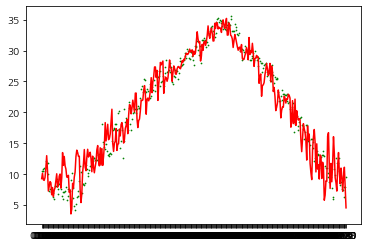

2공장 2지역 온도 Max R2 Score 0.9229669248165078


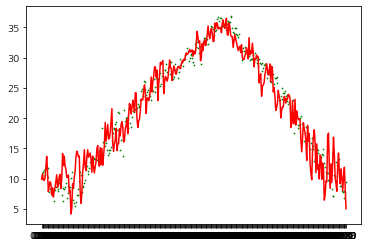

2공장 3지역 온도 Max R2 Score 0.9194793936830319


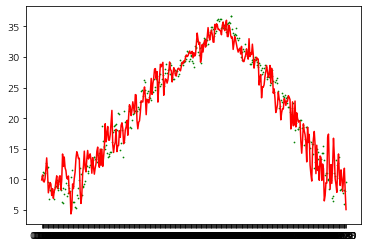

2공장 1지역 온도 Min R2 Score 0.9133881344209409


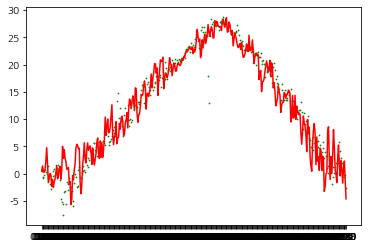

2공장 2지역 온도 Min R2 Score 0.9183821150853022


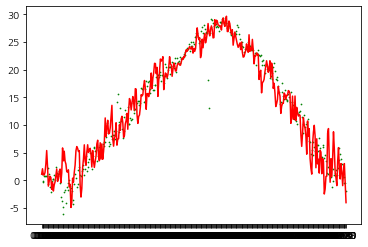

2공장 3지역 온도 Min R2 Score 0.9176959268163939


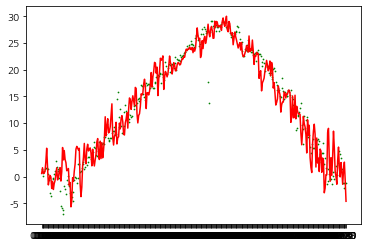

2공장 1지역 온도 Mean R2 Score 0.9243975687336439


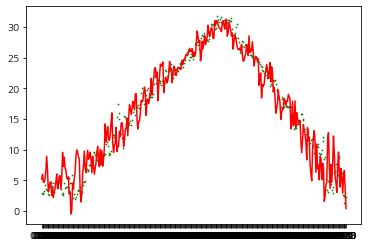

2공장 2지역 온도 Mean R2 Score 0.9265674481652171


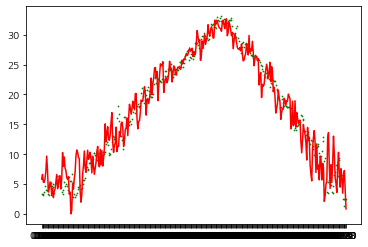

2공장 3지역 온도 Mean R2 Score 0.9228735937135741


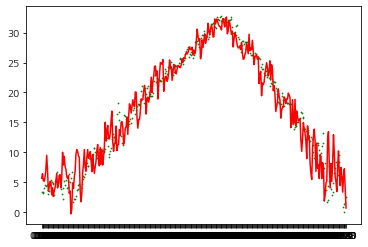

2공장 1지역 코일온도 Max R2 Score 0.9230092133051773


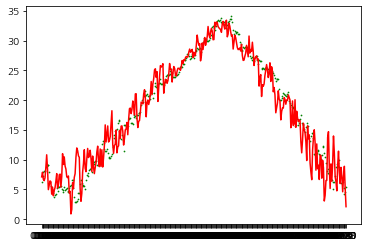

2공장 2지역 코일온도 Max R2 Score 0.9206843408433579


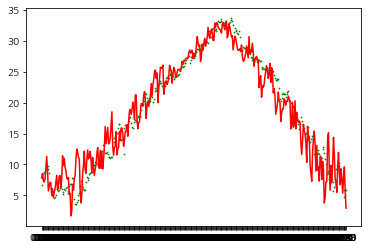

2공장 3지역 코일온도 Max R2 Score 0.9228510365987


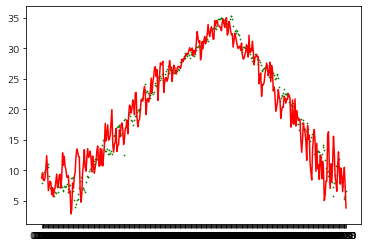

2공장 1지역 코일온도 Min R2 Score 0.9253380191500497


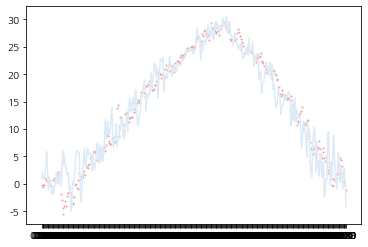

2공장 2지역 코일온도 Min R2 Score 0.926104243332179


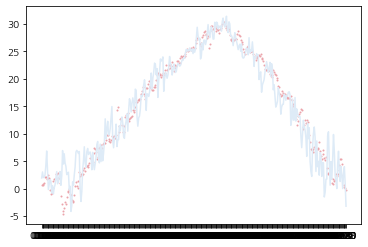

2공장 3지역 코일온도 Min R2 Score 0.9273789296783156


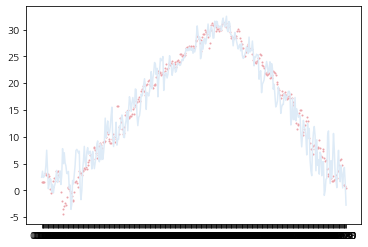

2공장 1지역 코일온도 Mean R2 Score 0.9271387867058604


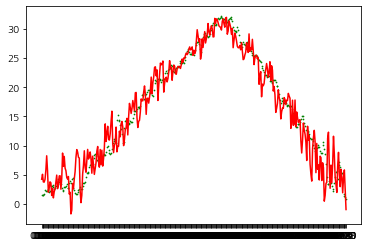

2공장 2지역 코일온도 Mean R2 Score 0.9262634985075384


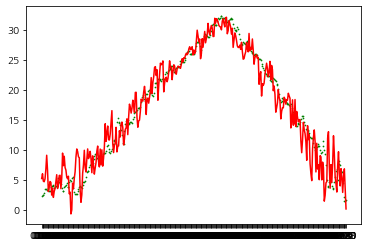

2공장 3지역 코일온도 Mean R2 Score 0.9261287884995539


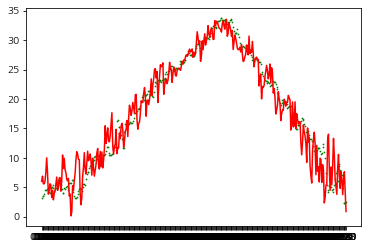

In [227]:
# plant 2
model = LinearRegression()

# 공장 내부
a2 = []
for i in range(1,4):
    X = train_df
    y = p2tmp_day_max['plant2_train.tem_in_loc{}'.format(i)]
    temp_model = model.fit(X, y)
    print('2공장 {}지역 온도 Max R2 Score'.format(i), temp_model.score(X, y))
    w.append([temp_model.coef_, temp_model.intercept_])
    a2.append(temp_model.predict(test_df))
    plt.scatter(y.index, y, s= 0.5, color ='g')
    plt.plot(temp_model.predict(X), color='r')
    plt.show()
b2 = []    
for i in range(1,4):
    X = train_df
    y = p2tmp_day_min['plant2_train.tem_in_loc{}'.format(i)]
    temp_model = model.fit(X, y)
    print('2공장 {}지역 온도 Min R2 Score'.format(i), temp_model.score(X, y))
    w.append([temp_model.coef_, temp_model.intercept_])
    b2.append(temp_model.predict(test_df))
    plt.scatter(y.index, y, s= 0.5, color ='g')
    plt.plot(temp_model.predict(X), color='r')
    plt.show()

c2 = []    
for i in range(1,4):
    X = train_df
    y = p2tmp_day_mean['plant2_train.tem_in_loc{}'.format(i)]
    temp_model = model.fit(X, y)
    print('2공장 {}지역 온도 Mean R2 Score'.format(i), temp_model.score(X, y))
    w.append([temp_model.coef_, temp_model.intercept_])
    c2.append(temp_model.predict(test_df))
    plt.scatter(y.index, y, s= 0.5, color ='g')
    plt.plot(temp_model.predict(X), color='r')
    plt.show()

# 코일 온도    
d2 = []
for i in range(1,4):
    X = train_df
    y = p2tmp_day_max['plant2_train.tem_coil_loc{}'.format(i)]
    temp_model = model.fit(X, y)
    print('2공장 {}지역 코일온도 Max R2 Score'.format(i), temp_model.score(X, y))
    w.append([temp_model.coef_, temp_model.intercept_])
    d2.append(temp_model.predict(test_df))
    plt.scatter(y.index, y, s= 0.5, color ='g')
    plt.plot(temp_model.predict(X), color='r')
    plt.show()
e2 = []    
for i in range(1,4):
    X = train_df
    y = p2tmp_day_min['plant2_train.tem_coil_loc{}'.format(i)]
    temp_model = model.fit(X, y)
    print('2공장 {}지역 코일온도 Min R2 Score'.format(i), temp_model.score(X, y))
    w.append([temp_model.coef_, temp_model.intercept_])
    e2.append(temp_model.predict(test_df))
    plt.scatter(y.index, y, s= 1, color ='#eba4ab')
    plt.plot(temp_model.predict(X), color='#deebf7')
    plt.show()

f2 = []    
for i in range(1,4):
    X = train_df
    y = p2tmp_day_mean['plant2_train.tem_coil_loc{}'.format(i)]
    temp_model = model.fit(X, y)
    print('2공장 {}지역 코일온도 Mean R2 Score'.format(i), temp_model.score(X, y))
    w.append([temp_model.coef_, temp_model.intercept_])
    f2.append(temp_model.predict(test_df))
    plt.scatter(y.index, y, s= 0.5, color ='g')
    plt.plot(temp_model.predict(X), color='r')
    plt.show()


2공장 1지역 코일온도 Min R2 Score 0.9133881344209409


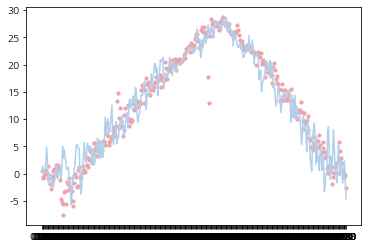

In [252]:
for i in range(1,2):
    X = train_df
    y = p2tmp_day_min['plant2_train.tem_in_loc{}'.format(i)]
    temp_model = model.fit(X, y)
    print('2공장 {}지역 코일온도 Min R2 Score'.format(i), temp_model.score(X, y))
    w.append([temp_model.coef_, temp_model.intercept_])
    e2.append(temp_model.predict(test_df))
    plt.scatter(y.index, y, s = 10, color ='#eba4ab')
    plt.plot(temp_model.predict(X), color='#b2d0ec')
    plt.show()


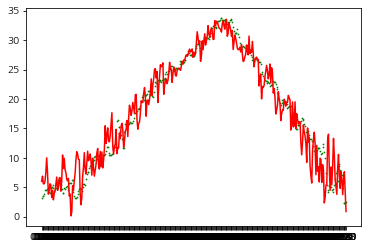

In [224]:
plt.scatter(y.index, y, s= 0.5, color ='g')
plt.plot(temp_model.predict(X), color='r')
plt.show()

In [144]:
len(w)
w[35]

[array([-2.69435154e-01, -6.01967505e-02,  3.97594893e-01, -6.48616975e+02,
         1.18027451e-02, -3.87402251e-01, -2.81587698e+00,  4.56307964e-02,
         1.62900480e+00]),
 6.634813799119669]

<BarContainer object of 8 artists>

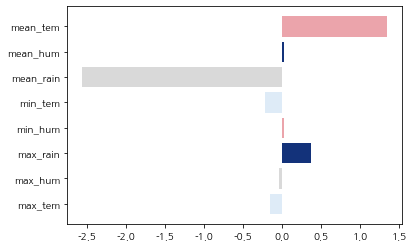

In [164]:
label = ['max_tem', 'max_hum', 'max_rain','min_rain','min_hum','min_tem','mean_rain','mean_hum','mean_tem']
label = train_df.columns
label = ['mean_rain', 'mean_tem']
label = ['max_tem', 'max_hum', 'max_rain','min_hum','min_tem','mean_rain','mean_hum','mean_tem']
# plt.barh(label,w[15][0][[6,8]])
plt.barh(label,w[15][0][[0,1,2,4,5,6,7,8]], color=['#deebf7', '#d9d9d9', '#13327a', '#eba4ab', '#deebf7', '#d9d9d9', '#13327a', '#eba4ab'])

# plt.
# w[0][0]

# 습도 예측

In [60]:
weight = 0.9
ahum = []
for i in range(1,4):
    p1hummax = weight * test_df['max_hum'] + (1-weight) * np.mean(p1tmp_day_max['plant1_train.hum_in_loc{}'.format(i)])
    p1hummin = weight *test_df['min_hum'] + (1-weight) * np.mean(p1tmp_day_min['plant1_train.hum_in_loc{}'.format(i)])
    p1hummean = weight *test_df['mean_hum'] + (1-weight) * np.mean(p1tmp_day_mean['plant1_train.hum_in_loc{}'.format(i)])
    # max min mean
    ahum.append([p1hummax.values, p1hummin.values, p1hummean.values])

bhum = []
for i in range(1,4):
    p2hummax = weight * test_df['max_hum'] + (1-weight) * np.mean(p2tmp_day_max['plant2_train.hum_in_loc{}'.format(i)])
    p2hummin = weight * test_df['min_hum'] + (1-weight) * np.mean(p2tmp_day_min['plant2_train.hum_in_loc{}'.format(i)])
    p2hummean = weight * test_df['mean_hum'] + (1-weight) * np.mean(p2tmp_day_mean['plant2_train.hum_in_loc{}'.format(i)])
    # max min mean
    bhum.append([p2hummax.values, p2hummin.values, p2hummean.values])

# Weather Finder 

In [61]:
weather_finder = [[[a,b,c],[d,e,f], ahum],[[a2,b2,c2],[d2,e2,f2], bhum]]
weather_index = list(test_df.index)

# Time Finder

In [62]:
time_finder = [[p1_tem_times, p1_coil_times, p1_hum_times], [p2_tem_times,p2_coil_times,p2_hum_times]]
time_index=[]
x = p1time.index
for i in range(len(x)):
    if i%3 == 0:
        time_index.append(x[i])

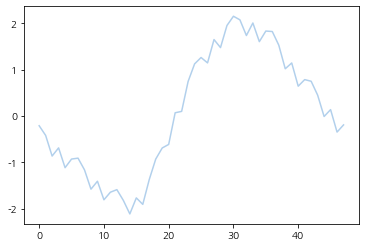

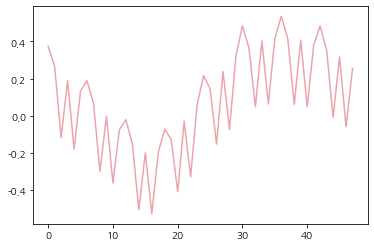

In [238]:
plt.plot(time_finder[0][0][2], color='#b2d0ec')
plt.show()
plt.plot(time_finder[0][1][1], color='#eba4ab')

# 이슬점 계산

In [63]:
def cal_dewp(tem, hum):
    dewp1 = 0
    cons1 = 3.61633*10**12
    cons11 = 273.33
    cons12 = -6150.6
    dewp2 = 0
    cons2 = 1.40574*10**10
    cons21 = -3928.5
    cons22 = 231.667
            
    if tem < 0:
        pa = cons1*np.exp(cons12/(tem+cons11))
    else:
        pa = cons2*np.exp(cons21/(tem+cons22))
    # pa = 포화수증기압

    subpa = pa*hum*0.01

    dewp1 = (cons12/(np.log(subpa/cons1)))-cons11 
    dewp2 = (cons21/(np.log(subpa/cons2)))-cons22

    if subpa<=611:
        return dewp1
    else:
        return dewp2

# Logistic Regression 학습

In [170]:
# plant1 데이터 전처리
p1train = pd.read_csv('C:/Users/svsta/OneDrive/Portfolio/공모전/날씨 빅데이터 콘테스트/Plant Data/plant1_train.csv')
p1train.dropna(inplace=True)
p1train.reset_index(inplace=True)

# 코일 온도 리스트
p1coils = []
p1coils = list(p1train['plant1_train.tem_coil_loc1'])
p1coils.extend(p1train['plant1_train.tem_coil_loc2'])
p1coils.extend(p1train['plant1_train.tem_coil_loc3'])

# 이슬점 변수
p1dewp = []
for i in p1train.iloc:
    p1dewp.append(cal_dewp(i['plant1_train.tem_in_loc1'], i['plant1_train.hum_in_loc1']))
for i in p1train.iloc:
    p1dewp.append(cal_dewp(i['plant1_train.tem_in_loc2'], i['plant1_train.hum_in_loc2']))
for i in p1train.iloc:
    p1dewp.append(cal_dewp(i['plant1_train.tem_in_loc3'], i['plant1_train.hum_in_loc3']))

#데이터 합치기
plant_X = pd.DataFrame(p1coils, p1dewp)
plant_X.reset_index(inplace=True)
plant_X.columns = ['코일온도', '이슬점']
# 결로 데이터
plant_y = list(p1tmp['plant1_train.cond_loc1'])
plant_y.extend(list(p1tmp['plant1_train.cond_loc2']))
plant_y.extend(list(p1tmp['plant1_train.cond_loc3']))

In [171]:
# LR 플랜트 1 이슬점, 코일온도 약12~13만개 데이터 학습, test size 0.25
# 테스트 개수 약 4만개 
X = plant_X
y = pd.DataFrame(plant_y)
X.dropna(inplace=True)
y.dropna(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

C:\Users\svsta\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Test Data Row 별 예측

In [66]:
test_data = pd.read_csv('C:/Users/svsta/OneDrive/Portfolio/공모전/날씨 빅데이터 콘테스트/203718.csv')

In [67]:
temp_24 = []
temp_48 = []
temp = []

for i in test_data.iloc:
    p, l = -1, -1
    if i['PLANT'] == 1:
        p = 0
        if i['LOC'] == 1:
            l = 0
        elif i['LOC'] == 2:
            l = 1
        else:
            l = 2
    else:
        p = 1
        if i['LOC'] == 1:
            l = 0
        elif i['LOC'] == 2:
            l = 1
        else:
            l = 2

    # 24시간 예측
    tch = 0
    tch_list = []
    for j in time_finder[p]: #온도 코일 습도
        t_i = j[l][time_index.index(int(i.X24H_TMA.split()[1].replace(':','')))] #24시간
        max_pch = weather_finder[p][tch][0][l][weather_index.index(i.X24H_TMA.split()[0].replace('-','')[4:])]
        min_pch = weather_finder[p][tch][1][l][weather_index.index(i.X24H_TMA.split()[0].replace('-','')[4:])]
        mean_pch = weather_finder[p][tch][2][l][weather_index.index(i.X24H_TMA.split()[0].replace('-','')[4:])]
        if t_i - np.mean(j[l]) > 0:
            t_i = (t_i - np.mean(j[l])) / (np.max(j[l]) - np.mean(j[l]))
            a = mean_pch + (max_pch - mean_pch) * t_i
        else:
            t_i = (t_i - np.mean(j[l])) / (np.mean(j[l]) - np.min(j[l]))
            a = mean_pch + (mean_pch - min_pch) * t_i
        tch_list.append(a) # 온도 코일 습도 예측값
        tch += 1
    temp_24.append(tch_list) # Row 별 온도 코일 습도 예측값
    
    # 48시간 예측
    tch = 0
    tch_list = []
    for j in time_finder[p]: #온도 코일 습도
        t_i = j[l][time_index.index(int(i.X48H_TMA.split()[1].replace(':','')))] #24시간
        max_pch = weather_finder[p][tch][0][l][weather_index.index(i.X48H_TMA.split()[0].replace('-','')[4:])]
        min_pch = weather_finder[p][tch][1][l][weather_index.index(i.X48H_TMA.split()[0].replace('-','')[4:])]
        mean_pch = weather_finder[p][tch][2][l][weather_index.index(i.X48H_TMA.split()[0].replace('-','')[4:])]
        if t_i - np.mean(j[l]) > 0:
            t_i = (t_i - np.mean(j[l])) / (np.max(j[l]) - np.mean(j[l]))
            a = mean_pch + (max_pch - mean_pch) * t_i
        else:
            t_i = (t_i - np.mean(j[l])) / (np.mean(j[l]) - np.min(j[l]))
            a = mean_pch + (mean_pch - min_pch) * t_i
        tch_list.append(a) # 온도 코일 습도 예측값
        tch += 1
    temp_48.append(tch_list) # Row 별 온도 코일 습도 예측값

In [68]:
# 이슬점 변수
dewp_24 = []
dewp_48 = []
for i in temp_24:
    dewp_24.append(cal_dewp(i[0], i[2]))
for i in temp_48:
    dewp_48.append(cal_dewp(i[0], i[2]))

In [69]:
tmp = []
for i in range(len(temp_24)):
    tmp.append([dewp_24[i], temp_24[i][1]])
    
result_24 = pd.DataFrame(tmp, columns = ['dewp', 'coil'])

tmp = []
for i in range(len(temp_24)):
    tmp.append([dewp_48[i], temp_48[i][1]])
    
result_48 = pd.DataFrame(tmp, columns = ['dewp', 'coil'])

In [70]:
cond_24 = log_reg.predict(result_24)
prob_24 = log_reg.predict_proba(result_24)[:, 1]
cond_48 = log_reg.predict(result_48)
prob_48 = log_reg.predict_proba(result_48)[:, 1]
prob_24 = list(map(int, prob_24*100))
prob_48 = list(map(int, prob_48*100))
final_result = pd.DataFrame([cond_24, prob_24, cond_48, prob_48])
final_result.T.to_csv('final_result4.csv')

In [71]:
final_result.T[final_result.T[0]==1]

,0,1,2,3
3,1.0,94.0,1.0,99.0
4,1.0,99.0,1.0,99.0
12,1.0,99.0,1.0,99.0
14,1.0,99.0,1.0,99.0
16,1.0,99.0,1.0,99.0
...,...,...,...,...
3472,1.0,95.0,1.0,99.0
3488,1.0,54.0,0.0,0.0
3489,1.0,96.0,0.0,0.0
3491,1.0,99.0,1.0,70.0


In [72]:
final_result.T[final_result.T[2]==1]

,0,1,2,3
3,1.0,94.0,1.0,99.0
4,1.0,99.0,1.0,99.0
12,1.0,99.0,1.0,99.0
14,1.0,99.0,1.0,99.0
16,1.0,99.0,1.0,99.0
...,...,...,...,...
3472,1.0,95.0,1.0,99.0
3475,0.0,0.0,1.0,87.0
3491,1.0,99.0,1.0,70.0
3517,1.0,97.0,1.0,99.0


In [77]:
p2tmp

,Unnamed: 0,plant2_train.mea_ddhr,plant2_train.tem_in_loc1,plant2_train.hum_in_loc1,plant2_train.tem_coil_loc1,plant2_train.tem_in_loc2,plant2_train.hum_in_loc2,plant2_train.tem_coil_loc2,plant2_train.tem_in_loc3,plant2_train.hum_in_loc3,plant2_train.tem_coil_loc3,plant2_train.tem_out_loc1,plant2_train.hum_out_loc1,plant2_train.cond_loc1,plant2_train.cond_loc2,plant2_train.cond_loc3,datetime_x,date_x,time_x
0,1,2016-07-19 18:00,22.39,55.46,27.46,22.48,56.17,29.71,21.94,56.32,30.70,17.72,62.94,0.0,0.0,0.0,1.468919e+09,0719,1800
1,2,2016-07-19 21:00,17.81,62.64,27.08,18.09,61.94,27.88,17.75,61.78,28.61,11.37,76.95,0.0,0.0,0.0,1.468930e+09,0719,2100
2,3,2016-07-20 0:00,15.13,66.70,26.93,15.49,66.42,26.74,15.89,64.87,27.27,9.79,79.46,0.0,0.0,0.0,1.468940e+09,0720,0
3,4,2016-07-20 3:00,13.82,68.53,26.47,14.03,69.14,26.01,14.64,67.06,26.93,8.35,81.56,0.0,0.0,0.0,1.468951e+09,0720,300
4,5,2016-07-20 6:00,12.93,73.87,26.20,13.05,74.48,25.51,13.69,71.83,26.47,7.68,89.10,0.0,0.0,0.0,1.468962e+09,0720,600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57908,57909,2019-03-31 23:00,9.18,35.96,9.22,9.11,37.12,9.72,8.29,37.82,9.53,4.72,50.98,0.0,0.0,0.0,1.554041e+09,0331,2300
57909,57910,2019-03-31 23:10,9.18,36.32,9.18,9.08,37.58,9.68,8.26,38.34,9.57,4.72,52.11,0.0,0.0,0.0,1.554041e+09,0331,2310
57910,57911,2019-03-31 23:20,9.24,36.51,9.22,9.02,38.25,9.76,8.29,38.92,9.60,4.66,51.01,0.0,0.0,0.0,1.554042e+09,0331,2320
57911,57912,2019-03-31 23:30,9.05,36.29,9.11,9.05,38.13,9.76,8.32,39.13,9.49,4.57,51.47,0.0,0.0,0.0,1.554043e+09,0331,2330


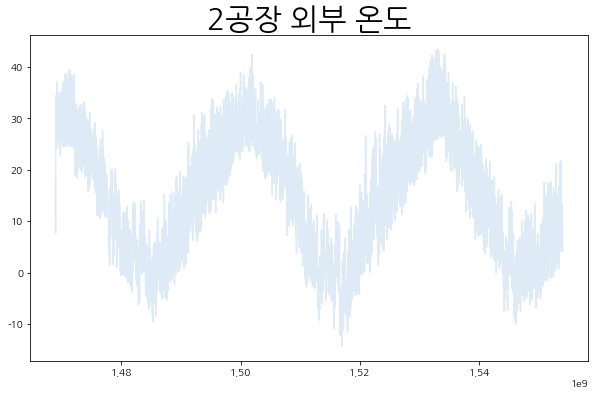

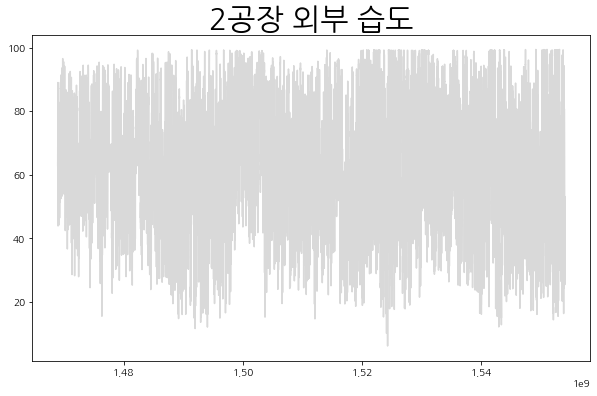

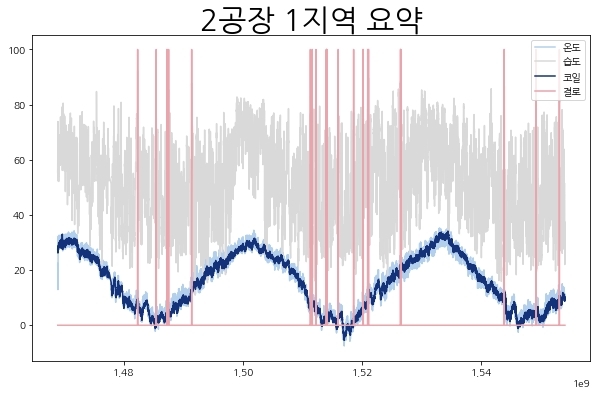

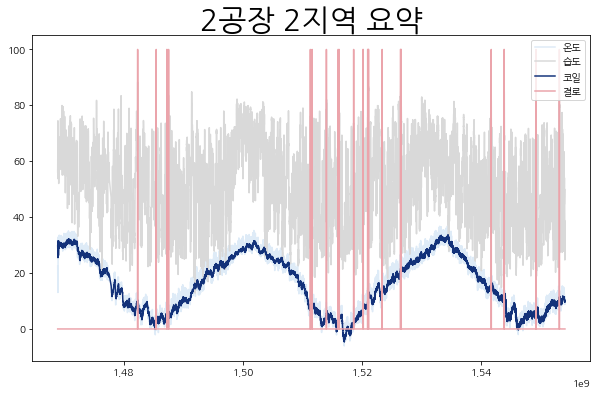

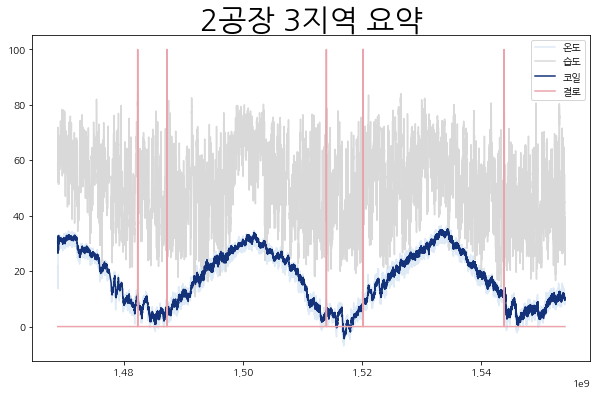

In [237]:
def plotting(n):
    if n == 1:
        plant_df = p1tmp
    else:
        plant_df = p2tmp
    l1tem = plant_df['plant{}_train.tem_in_loc1'.format(n)]
    l2tem = plant_df['plant{}_train.tem_in_loc2'.format(n)]
    l3tem = plant_df['plant{}_train.tem_in_loc3'.format(n)]
    l1hum = plant_df['plant{}_train.hum_in_loc1'.format(n)]
    l2hum = plant_df['plant{}_train.hum_in_loc2'.format(n)]
    l3hum = plant_df['plant{}_train.hum_in_loc3'.format(n)]
    l1coil = plant_df['plant{}_train.tem_coil_loc1'.format(n)]
    l2coil = plant_df['plant{}_train.tem_coil_loc2'.format(n)]
    l3coil = plant_df['plant{}_train.tem_coil_loc3'.format(n)]
    outtem = plant_df['plant{}_train.tem_out_loc1'.format(n)]
    outhum = plant_df['plant{}_train.hum_out_loc1'.format(n)]

    l1cond = plant_df['plant{}_train.cond_loc1'.format(n)]
    l2cond = plant_df['plant{}_train.cond_loc2'.format(n)]
    l3cond = plant_df['plant{}_train.cond_loc3'.format(n)]

    plt.figure(figsize=(10,6))
#     grid = plt.GridSpec(7,3)
#     plt.subplot(grid[0,0])
    plt.rcParams["font.family"] = 'NanumGothic'
    plt.plot(plant_df['datetime_x'],  outtem, color='#deebf7')
    plt.title('{}공장 외부 온도'.format(n), size=30)
    plt.show()
    
    plt.figure(figsize=(10,6))
#     plt.subplot(grid[0,1])
    plt.plot(plant_df['datetime_x'],  outhum, color='#d9d9d9')
    plt.title('{}공장 외부 습도'.format(n), size=30)
    plt.show()

    plt.figure(figsize=(10,6))
#     plt.subplot(grid[1,0])
    plt.plot(plant_df['datetime_x'],  l1tem, color='#b2d0ec')
    plt.title('{}공장 1지역 요약'.format(n), size=30)
#     plt.show()
#     plt.subplot(grid[1,1])
#     plt.figure(figsize=(10,6))
    plt.plot(plant_df['datetime_x'],  l1hum, color='#d9d9d9')
#     plt.title('공장 1지역 습도', size=30)
#     plt.show()
#     plt.figure(figsize=(10,6))
#     plt.subplot(grid[1,2])
    plt.plot(plant_df['datetime_x'],  l1coil, color = '#13327a')
#     plt.title('공장 1지역 코일 표면온도', size=30)
#     plt.show()

#     plt.figure(figsize=(10,6))
#     plt.subplot(grid[2,1])
    plt.plot(plant_df['datetime_x'], l1cond*100, color = '#eba4ab')
#     plt.title('공장 1지역 결로 발생여부', size=30)

    plt.legend(['온도', '습도', '코일', '결로'], loc='upper right')
    plt.show()

    plt.figure(figsize=(10,6))

#     plt.subplot(grid[3,0])
    plt.plot(plant_df['datetime_x'],  l2tem, color='#deebf7')
    plt.title('{}공장 2지역 요약'.format(n), size=30)
#     plt.show()
    
    
#     plt.figure(figsize=(10,6))
#     plt.subplot(grid[3,1])
    plt.plot(plant_df['datetime_x'],  l2hum, color='#d9d9d9')
#     plt.title('공장 2지역 습도', size=30)
#     plt.show()
    
#     plt.figure(figsize=(10,6))
#     plt.subplot(grid[3,2])
    plt.plot(plant_df['datetime_x'],  l2coil, color ='#13327a')
#     plt.title('공장 2지역 코일 표면온도', size=30)
#     plt.show()

#     plt.figure(figsize=(10,6))
#     plt.subplot(grid[4,1])
    plt.plot(plant_df['datetime_x'], l2cond*100, color = '#eba4ab')
#     plt.title('공장 2지역 결로 발생여부', size=30)
    plt.legend(['온도', '습도', '코일', '결로'], loc='upper right')
    plt.show()

    plt.figure(figsize=(10,6))
#     plt.subplot(grid[5,0])
    plt.plot(plant_df['datetime_x'],  l3tem, color='#deebf7')
    plt.title('{}공장 3지역 요약'.format(n), size=30)
#     plt.show()
#     plt.figure(figsize=(10,6))
#     plt.subplot(grid[5,1])
    plt.plot(plant_df['datetime_x'],  l3hum, color='#d9d9d9')
#     plt.title('공장 3지역 습도', size=30)
#     plt.show()
#     plt.figure(figsize=(10,6))
#     plt.subplot(grid[5,2])
    plt.plot(plant_df['datetime_x'],  l3coil, color = '#13327a')
#     plt.title('공장 3지역 코일 표면온도', size=30)
#     plt.show()

#     plt.figure(figsize=(10,6))
#     plt.subplot(grid[6,1])
    plt.plot(plant_df['datetime_x'], l3cond*100, color ='#eba4ab')
#     plt.title('공장 3지역 결로 발생여부', size=30)
    plt.legend(['온도', '습도', '코일', '결로'], loc='upper right')
    plt.show()
    
plotting(2)

In [ ]:
# 상관분석
import seaborn as sns

corr = pd.DataFrame.corr(method='pearson')
corr


plt.figure(figsize=(15,15))
sns.heatmap(data = dongne.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')


                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     5273.
Date:                Mon, 29 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:38:08   Log-Likelihood:             1.7858e+05
No. Observations:              173562   AIC:                        -3.572e+05
Df Residuals:                  173559   BIC:                        -3.571e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0690      0.001    104.938      0.0

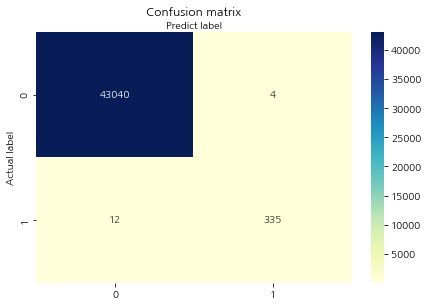

In [172]:
# 로지스틱 분석 정리, 도식화
import statsmodels.api as sm
from sklearn import metrics
import seaborn as sns

x2 = sm.add_constant(X)
model = sm.OLS(y, x2)
result = model.fit()
print(result.summary())

y_pred = log_reg.predict(X_test)
print(y_pred)
print(list(y_test))

print('정확도 :', metrics.accuracy_score(y_test, y_pred))

class_names = ['malignant', 'benign']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

cnf_metrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_metrix)

# 히트맨 생성
sns.heatmap(pd.DataFrame(cnf_metrix), annot=True, cmap='YlGnBu', fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.rcParams["font.family"] = 'NanumGothic'
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predict label")
plt.show()
